# Severstal: Steel Defect Detection

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
import fastai.utils
fastai.utils.show_install()



```text
=== Software === 
python        : 3.7.3
fastai        : 1.0.58
fastprogress  : 0.1.21
torch         : 1.2.0
nvidia driver : 435.21
torch cuda    : 10.0.130 / is available
torch cudnn   : 7602 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16160MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-4.15.0-1051-aws-x86_64-with-debian-buster-sid
distro        : #53-Ubuntu SMP Wed Sep 18 13:35:53 UTC 2019
conda env     : base
python        : /home/ubuntu/anaconda3/bin/python
sys.path      : /home/ubuntu/kaggle_severstal
/home/ubuntu/anaconda3/lib/python37.zip
/home/ubuntu/anaconda3/lib/python3.7
/home/ubuntu/anaconda3/lib/python3.7/lib-dynload

/home/ubuntu/.local/lib/python3.7/site-packages
/home/ubuntu/anaconda3/lib/python3.7/site-packages
/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions
/home/ubuntu/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the

In [10]:
! pip install opencv-python

In [35]:
import cv2

## Getting the data

In [16]:
! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /home/ubuntu/anaconda3/lib/python3.7/site-packages (1.5.6)


In [17]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [4]:
path = Config.data_path()/'severstal-steel-defect-detection'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection')

In [19]:
! kaggle competitions download -c severstal-steel-defect-detection -f train.csv -p {path}  
! kaggle competitions download -c severstal-steel-defect-detection -f train_images.zip -p {path}  
! kaggle competitions download -c severstal-steel-defect-detection -f test_images.zip -p {path}  
! unzip -q -n {path}/train_images.zip -d {path}/train_images
! unzip -q -n {path}/test_images.zip -d {path}/test_images
! unzip -q -n {path}/train.csv.zip -d {path}

  0%|                                               | 0.00/6.91M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 6.91M/6.91M [00:00<00:00, 146MB/s]
 99%|██████████████████████████████████████▍| 1.15G/1.16G [00:08<00:00, 169MB/s]
100%|███████████████████████████████████████| 1.16G/1.16G [00:08<00:00, 143MB/s]
 99%|████████████████████████████████████████▋| 128M/129M [00:00<00:00, 163MB/s]
100%|█████████████████████████████████████████| 129M/129M [00:00<00:00, 178MB/s]


In [20]:
! chmod 555 '/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train.csv'

## Setup

In [5]:
path_img = path/'train_images'

In [6]:
path_test = path/'test_images'

In [7]:
path_lbl = path/'labels'

## Data Ingestion

In [8]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


## Process labels

In [9]:
def process_csv(path, csv):
    
    train_df = pd.read_csv(path/csv)
    
    train_df['label'] = train_df.apply(lambda x : x['ImageId_ClassId'].split('_')[-1], axis=1)
    train_df['image_id'] = train_df.apply(lambda x : x['ImageId_ClassId'].split('_')[0], axis=1)

    proc_train_df = train_df.pivot(index='image_id', columns='label', values='EncodedPixels').reset_index(drop=False)

    proc_train_df = proc_train_df.fillna(value=' ')
    
    return proc_train_df

In [10]:
proc_train_df = process_csv(path, 'train.csv')

In [11]:
proc_train_df.head()

label,image_id,1,2,3,4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [18]:
## Save RLEs as PNGs

In [33]:
! mkdir '/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels'

In [34]:
def make_labels_rle(path, train, proc_train_df, labels):
    for index, row in proc_train_df.iterrows():
        save_rle_label_image(path, row, train, labels)

In [35]:
def save_rle_label_image(path, mask_df, train, labels):
    image_id, rles = mask_df[0], mask_df[1:]
    image_fn = re.search('(.*?)\.jpg', image_id).group(1)+'.png'
    shape = open_image(path/train/image_id).shape[-2:]
    final_mask = torch.zeros((1, *shape))
    for k, rle in enumerate(rles):
        if isinstance(rle, str):
            mask = open_mask_rle(rle, shape).px.permute(0, 2, 1)
            final_mask += (k+1)*mask
    mask_img = image2np(final_mask.data).astype(np.uint8)
    PIL.Image.fromarray(mask_img).save(path/labels/image_fn, 'png')

In [36]:
make_labels_rle(path, 'train_images', proc_train_df, path_lbl)

## Explore 

In [29]:
get_y_fn = lambda x: (path_lbl/f'{x.stem}').with_suffix('.png')

In [30]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/cf1152c44.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/b54038841.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/1c97d1861.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/6ac1d05d3.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/f0b2483fa.jpg')]

In [31]:
lbl_names = get_image_files(path_lbl)
lbl_names[:5]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/1863eb011.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/62cf0b008.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/1c2a39896.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/8bfc35309.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/e6207db1a.png')]

torch.Size([3, 256, 1600])


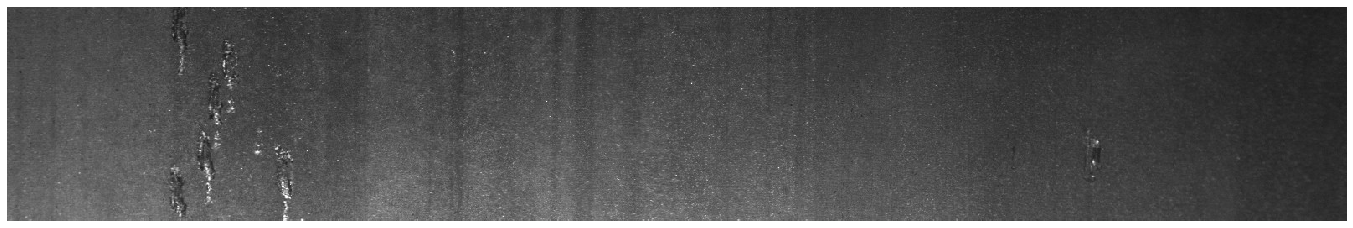

In [32]:
img_f = fnames[3]
img = open_image(img_f)
print(img.shape)
img.show(figsize=(24,24))

{0, 3}


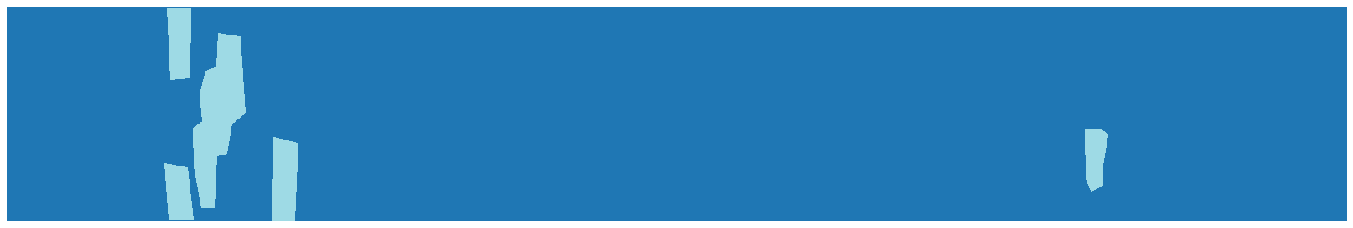

In [33]:
mask = open_mask(get_y_fn(img_f))
print(set(mask.data.numpy().flatten()))
mask.show(figsize=(24,24), alpha=1)

In [34]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 256, 1600]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

## Setup Data Block

In [19]:
codes = [0,1,2,3,4]

In [20]:
from fastai.utils.mem import *
size = src_size//2
print(size)

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

[128 800]
using bs=8, have 16149MB of GPU RAM free


In [21]:
size = size//2
print(size)

[ 64 400]


In [22]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(valid_pct=0.2)
        .label_from_func(get_y_fn, classes=codes))

In [23]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

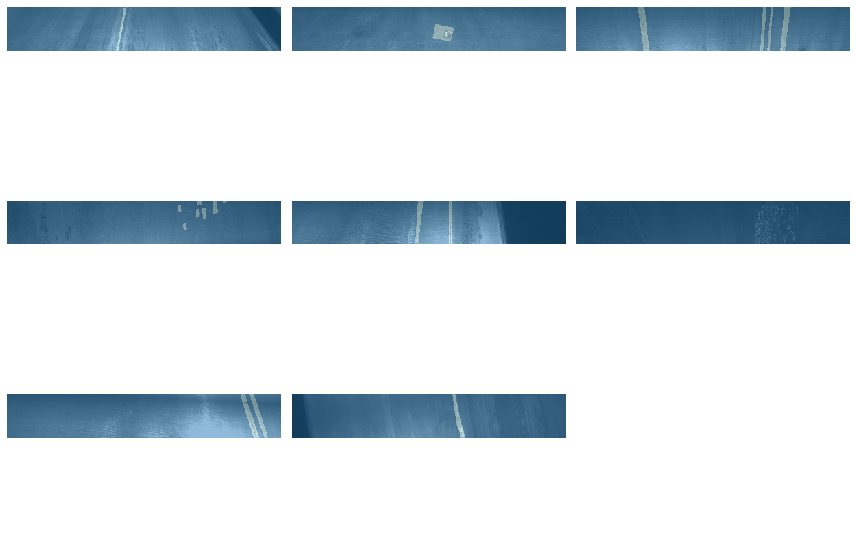

In [24]:
data.show_batch(3, figsize=(12,9))

## Create Learner

In [25]:
print(bs, size)

8 [ 64 400]


In [26]:
arch = models.resnet50

In [27]:
# Reference: @lafoss on Kaggle - Kernel - Severstal: fast.ai 256x256 crops
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n,c = targs.shape[0], input.shape[1]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect,union = [],[]
    for i in range(1,c):
        intersect.append(((input==i) & (targs==i)).sum(-1).float())
        union.append(((input==i).sum(-1) + (targs==i).sum(-1)).float())
    intersect = torch.stack(intersect)
    union = torch.stack(union)
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [28]:
# from fastai.metrics import dice
# dice_score = partial(dice, iou=False)
f_score = partial(fbeta, thresh=0.2)
learn = unet_learner(data, arch, metrics=[dice])

In [28]:
# Is this needed?
# learn.loss_func = BCEWithLogitsLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


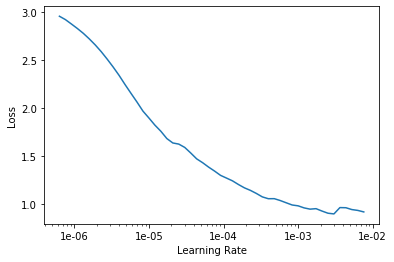

In [29]:
lr_find(learn)
learn.recorder.plot()

In [30]:
lr=1e-05

In [31]:
print(lr)

1e-05


In [32]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.103157,0.123522,0.770164,08:40
1,0.083093,0.068034,0.866568,08:41
2,0.080303,0.061863,0.859850,08:39
3,0.066680,0.057794,0.862390,08:40
4,0.064631,0.057102,0.862919,08:42


In [33]:
learn.save('stage-1-64-rn50')

In [34]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


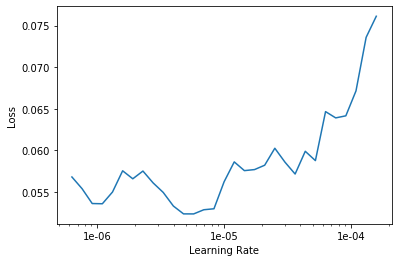

In [35]:
learn.lr_find()
learn.recorder.plot()

In [96]:
# Pick a value just before the slope goes upward, then 10x smaller
# 1e-05 --> 1e-06

In [37]:
# LR / 5 or LR / 10 - Discriminate learning
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,dice,time
0,0.066170,0.058406,0.854461,08:52
1,0.067030,0.055975,0.874655,08:52
2,0.062530,0.055874,0.872495,08:52
3,0.056530,0.054634,0.873782,08:53
4,0.058521,0.055263,0.868630,08:52


In [38]:
learn.save('stage-2-64-rn50')

In [97]:
# # TODO: CUDA Memory Error on 128, 800 resolution
# size = size*2
# print(size)

In [50]:
import torch
torch.cuda.empty_cache()

In [51]:
# # Resize data
# data = (src.transform(get_transforms(), size=size, tfm_y=True)
#         .databunch().normalize(imagenet_stats))

# data.batch_size = 4

# learn.data = data
# print(learn.data.batch_size)
# data.train_ds[0][0].shape

4


torch.Size([3, 128, 800])

In [34]:
learn.load('stage-2-64-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (10055 items)
x: SegmentationItemList
Image (3, 64, 400),Image (3, 64, 400),Image (3, 64, 400),Image (3, 64, 400),Image (3, 64, 400)
y: SegmentationLabelList
ImageSegment (1, 64, 400),ImageSegment (1, 64, 400),ImageSegment (1, 64, 400),ImageSegment (1, 64, 400),ImageSegment (1, 64, 400)
Path: /home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images;

Valid: LabelList (2513 items)
x: SegmentationItemList
Image (3, 64, 400),Image (3, 64, 400),Image (3, 64, 400),Image (3, 64, 400),Image (3, 64, 400)
y: SegmentationLabelList
ImageSegment (1, 64, 400),ImageSegment (1, 64, 400),ImageSegment (1, 64, 400),ImageSegment (1, 64, 400),ImageSegment (1, 64, 400)
Path: /home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05,

In [30]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


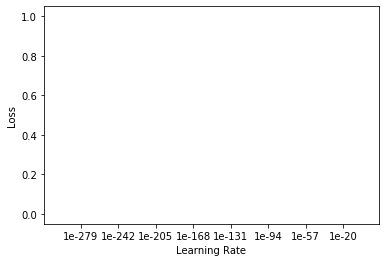

In [33]:
learn.lr_find()
learn.recorder.plot()

In [35]:
lr=1e-06
lr

1e-06

In [36]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.058616,0.051175,0.882580,08:45
1,0.060534,0.057944,0.870799,08:45
2,0.065012,0.050944,0.881356,08:45
3,0.063760,0.052668,0.878900,08:45
4,0.064797,0.051109,0.879643,08:45


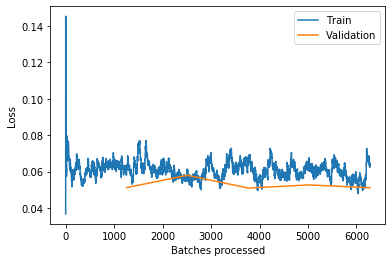

In [37]:
learn.recorder.plot_losses()

In [38]:
learn.save('stage-3-64-rn50')

In [42]:
learn.path = path

In [43]:
learn.path

PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection')

In [ ]:
interp = ClassificationInterpretation(learn, preds, y, losses)


In [43]:
learn.plot_multi_top_losses(save_misclassified=False)

AttributeError: 'Learner' object has no attribute 'plot_multi_top_losses'

### Augment image size for cycle

In [89]:
# # Resize data
# data = (src.transform(get_transforms(), size=[64,400], tfm_y=True)
#         .databunch().normalize(imagenet_stats))

# data.batch_size = 4

# learn.data = data
# print(learn.data.batch_size)
# data.train_ds[0][0].shape

In [90]:
# learn.freeze()

In [91]:
# learn.lr_find()
# learn.recorder.plot()

In [92]:
# lr=1e-04/5

In [93]:
# learn.fit_one_cycle(5, slice(lr))

In [41]:
learn.export()

In [95]:
# Exports
##############
# 10/10/2019 1:53pm - ResNet34
# Stage 1 - 64 x 400 
# Stage 2 - 64 x 400
# Stage 3 - 128 X 800
##############
# 10/10/2019 5:08pm - ResNet34
# Stage 1 - 64 x 400 
# Stage 2 - 64 x 400
# Stage 3 - 64 X 400

##############
# 12/10/2019 4:40pm - ResNet50
# Stage 1 - 64 x 400 
# Stage 2 - 64 x 400
# Stage 3 - 64 X 400

## Inference

In [44]:
tnames = get_image_files(path_test)
tnames[:5]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/73d60f24f.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/f99381ed5.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/c4405bef9.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/b991340c8.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/1ba63ec01.jpg')]

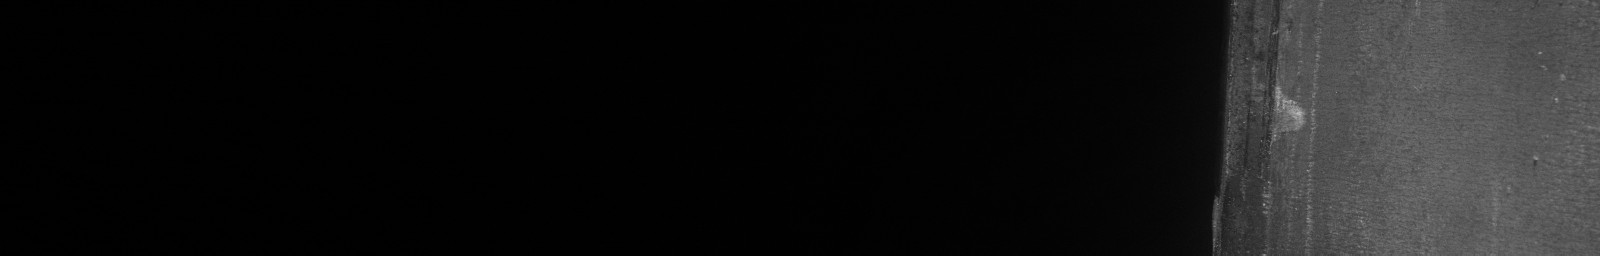

In [45]:
# Sample test image
img = open_image(path_test/'f99381ed5.jpg')
img

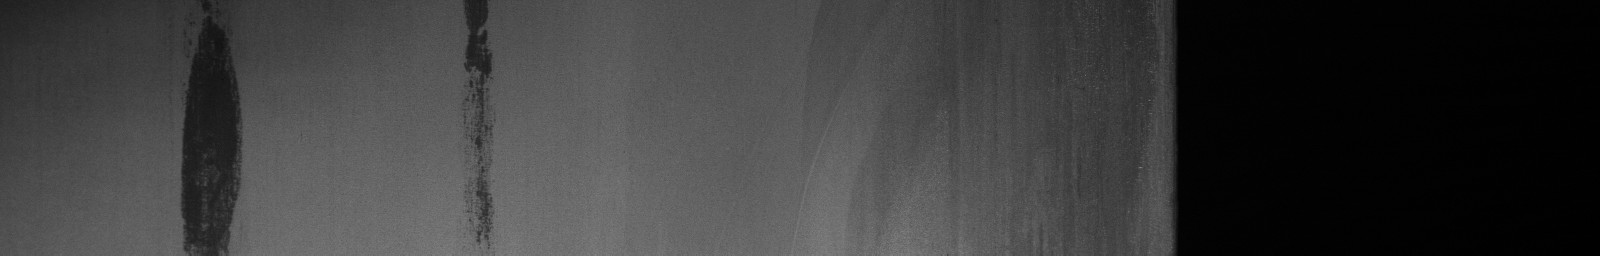

In [46]:
open_image(tnames[0])

In [12]:
# Setup test data
test_data = ItemList.from_folder(path/'test_images')

In [13]:
# Load learner
learn = load_learner(path, test=test_data, tfm_y=False)

In [14]:
# Predict
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [46]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py", line 270, in get
    fn = super().get(i)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 75, in get
    return self.items[i]
IndexError: index 0 is out of bounds for axis 0 with size 0


In [15]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [16]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability.cpu().data.numpy(), threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((64, 400), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [17]:
def get_rle(pred, thresh=0.2, min_size=50, scale=4):
    '''Get RLEs'''
    pred_mask, test_num = post_process(pred, thresh, min_size=min_size)
    pred_mask = pred_mask.repeat(scale, axis=0).repeat(scale, axis=1)
    rle  = mask2rle(pred_mask)
    return rle

In [18]:
min_size = 50

In [19]:
learn.data.classes

[0, 1, 2, 3, 4]

In [36]:
src_size

array([ 256, 1600])

In [37]:
fnames = [('_'.join([i.name, str(c)])) for i in learn.data.test_ds.items for c in learn.data.classes]

In [38]:
preds_list = [get_rle(j, thresh=0.4, min_size=400) for pred in preds for _,j in enumerate(pred)]

In [39]:
df = pd.DataFrame({'ImageId_ClassId':fnames, 'EncodedPixels':preds_list}, columns=['ImageId_ClassId', 'EncodedPixels'])

In [40]:
df = df[~df.ImageId_ClassId.str.contains("_0")]

In [41]:
df.head()

,ImageId_ClassId,EncodedPixels
1,73d60f24f.jpg_1,
2,73d60f24f.jpg_2,
3,73d60f24f.jpg_3,
4,73d60f24f.jpg_4,
6,f99381ed5.jpg_1,


In [94]:
! cp 'home/ubuntu/.fastai/data/severstal-steel-defect-detection/export.pkl' 'export.pkl'

cp: cannot stat 'home/ubuntu/.fastai/data/severstal-steel-defect-detection/export.pkl': No such file or directory


In [92]:
df.to_csv('submission.csv', index=False)